# GeoPandas Lab

In this workshop, we will explore Air Quality Index (AQI) data for cities and countries, along with some demographic data (population and mortality rates) for countries in 2024.

We will examine this data on a geospatial level using the `GeoPandas` module. With `GeoPandas`, we can create sophisticated maps that provide new ways to interpret data. Mapping information geographically can often reveal insights that are less obvious in traditional visualizations such as bar charts, scatter plots, or histograms.

---

**Learning Goals:**

- How to **create a geometry column** when latitude and longitude values are available
- How to **zoom in** on a selected continent
- How to **label countries**, appropriate to the type of data shown
- A simple approach to **handle missing data**


In [ ]:
import numpy as np # allows for efficient calculations and manipulation with arrays
import pandas as pd # allows for the use of data frames and application of data science
import matplotlib.pyplot as plt # used for object-oriented plotting or general plotting
import seaborn as sns # allows for visualizations
import regex as re # for manipulating strings
import geopandas as gpd # allows for geospatial analysis
from shapely.geometry import Point # used for converting lat and lon values to a polygon
from matplotlib.lines import Line2D # allows to manually change the objects that appear in the legend
from shapely import wkt # The data files were preprocessed before this workshop and may have been read incorrectly.
                        # WKT conversion helps transform the DataFrame into a proper GeoDataFrame.


# for creating a colorbar
import matplotlib.colors as mcolors

import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')


In [2]:
# read in the data

# Data for the countries(i.e country_name/label,polygon(geometry),etc.)
countries = gpd.read_file("/Users/Martin/Desktop/Main_Proj_Repo/DS_club/GeoPandas_Lab/data/countries/ne_110m_admin_0_countries.shp")



# -------

# Data for countries that have a data of the mean AQI and other demographic variables
Country_AQI_Data_2024 = pd.read_csv("/Users/Martin/Desktop/Main_Proj_Repo/DS_club/GeoPandas_Lab/data_transformed/Country_AQI_Data_2024.csv")

# -------

# Data for cities and their AQI values.
# This dataset contains the minimum, maximum, and mean AQI values for cities within each country.
# For instance, Russia will have three cities, each representing a different measure of central tendency (min, max, and mean).
# This is observed in more common, larger and more well-known countries. 
# For smaller countries, typically only one city is used to represent all three values (min, max, and mean).

Global_AQI_levels = pd.read_csv("/Users/Martin/Desktop/Main_Proj_Repo/DS_club/GeoPandas_Lab/data_transformed/Global_AQI_Levels.csv")


In [3]:
# Examine the types of dataframs


type(countries),type(Country_AQI_Data_2024),type(Global_AQI_levels)

(geopandas.geodataframe.GeoDataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

In [4]:
# convert the daframe to geodataframes



Country_AQI_Data_2024['geometry'] = Country_AQI_Data_2024['geometry'].apply(wkt.loads)
Country_AQI_Data_2024 = gpd.GeoDataFrame(Country_AQI_Data_2024, geometry='geometry')




## Convert available lat and lon values to a geometry value

In [5]:
# using Point for the conversion


Global_AQI_levels['geometry'] = [Point(yx) for yx in zip(Global_AQI_levels['lon'],Global_AQI_levels['lat'])]
# doing this will allow for a straigh forward conversion from dataframe to geodataframe

Global_AQI_levels = gpd.GeoDataFrame(Global_AQI_levels)

## Examine the Current State of Map


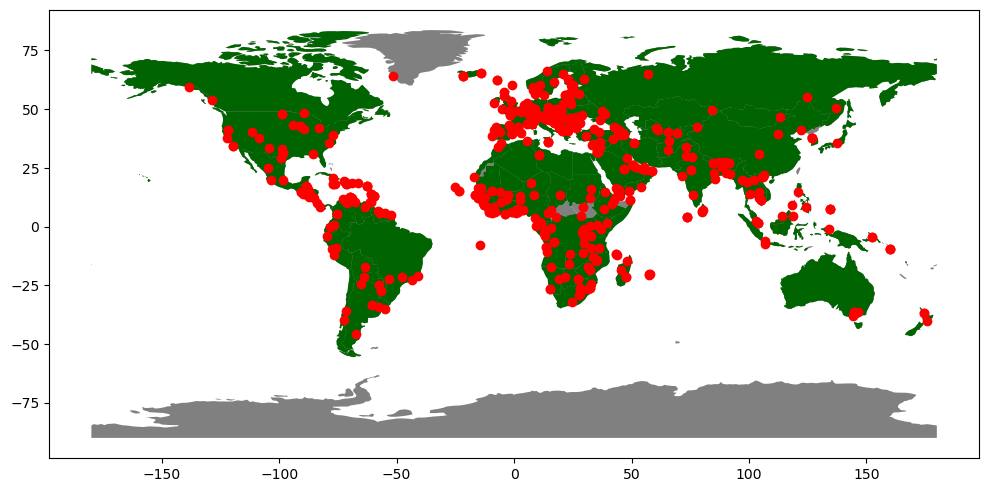

In [6]:
# simple plotting of the geodataframes using .plot()
fig, ax = plt.subplots(figsize=(12,8))



countries.plot(ax=ax,color='grey') # serve as the background for when the country has no data to represent
Country_AQI_Data_2024.plot(ax=ax,color='darkgreen')
Global_AQI_levels.plot(ax=ax,color='r')



plt.show()


# **Geo-Analysis**

In this section, we will define two functions, each of which will zoom in on a given continent.
One function will visualize AQI measurements for cities globally.
The other will create a density (choropleth) map that displays the distribution of a demographic variable alongside the mean AQI.

**Recall:**

- `countries` – Contains general information about countries. It will be useful for adding labels and handling missing data.

- `Country_AQI_Data_2024` – Contains mean AQI, population, and mortality data. Only certain countries have available data.

- `Global_AQI_levels` – Contains central tendency values of AQI measurements, typically for three cities per country. That means each country will have approximately three corresponding data points.


## Zooming in on the Continents



In [7]:
# define the map projections of each continent in the format of [xmin,xmax,ymin,ymax]
# these constants will assists with zooming in on the continents
 


oceania_proj = [95, 180, -50, 20]
europe_proj = [-10, 50, 36, 71]
na_proj = [-170, -45, 10, 85]
sa_proj = [-100, -30, -60, 15]
asia_proj = [60, 145, 5, 65]
africa_proj = [-20, 60, -38, 38]



In [8]:
# seprate data frames for each of the measures

Global_AQI_Levels_mins = Global_AQI_levels.loc[Global_AQI_levels.measure == 'min_aqi']

Global_AQI_Levels_means = Global_AQI_levels.loc[Global_AQI_levels.measure == 'mean_aqi']

Global_AQI_Levels_maxs = Global_AQI_levels.loc[Global_AQI_levels.measure == 'max_aqi']



#### Visual for AQI data by City

In [9]:
# function to visualize the AQI data for the cities
def AQI_analysis_cities(continent="",min=False,mean=False,max=False):
    """
    continent = str , min = bool ,mean = bool ,max = bool -> plot

    If a continent is provided, the function will return a visual of the inputted continent with all measures displayed and appropriate labels for countries in that continent.
    By default, the function will return the global map with all measures displayed.

    If a measure or measures are set to True, the function will return a visual display of those specified measure(s). 
    This behavior also applies when a continent is provided.
    
    """

    #------ 
    # define the constants


    # ---- 
    # creatng the legend
    ## custom legend labels
    aqi_labels_all = [
              "Min_AQI",
             "Mean_AQI",
              "Max_AQI"
                ]

    ## custom legend symbols
    aqi_handles_all = [
         Line2D([],[],color='none',markersize=10,marker='o',markerfacecolor='limegreen',markeredgecolor='none'),
         Line2D([],[],color='none',markersize=10,marker='o',markerfacecolor='gold',markeredgecolor='none'),
            Line2D([],[],color='none',markersize=10,marker='o',markerfacecolor='red',markeredgecolor='none')]
    
    # color for the country polygons

    bronze = '#8b6f47'


#----------------


#----Oceania-----
    if continent == "Oceania":

        fig, ax = plt.subplots(figsize=(12,8))

        # Plot countries and background

        # plot of the countries, these countries it plots will serve as the background and provide the labels
        # their being mapped to the same color for when the intention is to vizualize the AQI Data for cities
        # color will be set to grey when vizualizing density(chloropleth) plots of the AQI values
        countries.plot(ax=ax,color=bronze,edgecolor='k')
        # zoom into the projection of the continent
        plt.axis(oceania_proj)
        Country_AQI_Data_2024.plot(ax=ax, color=bronze, edgecolor='k')

        # Plot AQI data conditionally -- dependent of the measure
        aqi_labels = []
        aqi_handles = []

        # Below will be the code for when a measure(s) is specified as true along with a continent or not
        if min:
            Global_AQI_Levels_mins.plot(ax=ax, color='limegreen', alpha=0.7)
            aqi_labels.append("Min_AQI")
            aqi_handles.append(Line2D([],[], color='none', markersize=10, marker='o', markerfacecolor='limegreen', markeredgecolor='none'))

        if mean:
            Global_AQI_Levels_means.plot(ax=ax, color='gold', alpha=0.7)
            aqi_labels.append("Mean_AQI")
            aqi_handles.append(Line2D([],[], color='none', markersize=10, marker='o', markerfacecolor='gold', markeredgecolor='none'))

        if max:
            Global_AQI_Levels_maxs.plot(ax=ax, color='red', alpha=0.7)
            aqi_labels.append("Max_AQI")
            aqi_handles.append(Line2D([],[], color='none', markersize=10, marker='o', markerfacecolor='red', markeredgecolor='none'))

        # Styling
        ax.set_facecolor('deepskyblue')
        fig.set_facecolor('rosybrown')
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

        # Country labels
        [plt.annotate(countries.iloc[i].ADM0_A3,
                      (countries.iloc[i].geometry.representative_point().x,
                       countries.iloc[i].geometry.representative_point().y),
                      ha='center', fontsize=8, fontstyle='italic', annotation_clip=True)
         for i in np.arange(countries.shape[0])]

        # Legend and title
        if aqi_labels:
            plt.legend(labels=aqi_labels, handles=aqi_handles)
            title_label = " & ".join(aqi_labels)
            plt.title(f"AQI Distribution ({title_label}) by Cities for {continent} in 2024", fontsize=20)

        else:
             # plot of all measures(min,mean,max) in Oceania
            Global_AQI_Levels_mins.plot(ax=ax, color='limegreen', alpha=0.7)
            Global_AQI_Levels_means.plot(ax=ax, color='gold', alpha=0.7)
            Global_AQI_Levels_maxs.plot(ax=ax, color='red', alpha=0.7)

            # establish the legend
            plt.legend(labels=aqi_labels_all, handles=aqi_handles_all)

            # establish the title 
            plt.title(f'AQI Distrubtion by Cities for {continent} in 2024', fontsize=20)

            plt.show()

#----Asia-----
    elif continent == "Asia":
        fig, ax = plt.subplots(figsize=(12,8))
        countries.plot(ax=ax, color=bronze, edgecolor='k')
        plt.axis(asia_proj)
        Country_AQI_Data_2024.plot(ax=ax, color=bronze, edgecolor='k')
        aqi_labels = []
        aqi_handles = []
        if min:
            Global_AQI_Levels_mins.plot(ax=ax, color='limegreen', alpha=0.7)
            aqi_labels.append("Min_AQI")
            aqi_handles.append(Line2D([], [], color='none', markersize=10, marker='o', markerfacecolor='limegreen', markeredgecolor='none'))
        if mean:
            Global_AQI_Levels_means.plot(ax=ax, color='gold', alpha=0.7)
            aqi_labels.append("Mean_AQI")
            aqi_handles.append(Line2D([], [], color='none', markersize=10, marker='o', markerfacecolor='gold', markeredgecolor='none'))
        if max:
            Global_AQI_Levels_maxs.plot(ax=ax, color='red', alpha=0.7)
            aqi_labels.append("Max_AQI")
            aqi_handles.append(Line2D([], [], color='none', markersize=10, marker='o', markerfacecolor='red', markeredgecolor='none'))
        ax.set_facecolor('deepskyblue')
        fig.set_facecolor('rosybrown')
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
        [plt.annotate(countries.iloc[i].ADM0_A3,
                      (countries.iloc[i].geometry.representative_point().x,
                       countries.iloc[i].geometry.representative_point().y),
                      ha='center', fontsize=8, fontstyle='italic', annotation_clip=True)
         for i in np.arange(countries.shape[0])]
        if aqi_labels:
            plt.legend(labels=aqi_labels, handles=aqi_handles)
            title_label = " & ".join(aqi_labels)
            plt.title(f"AQI Distribution ({title_label}) by Cities for {continent}", fontsize=20)
        else:
            Global_AQI_Levels_mins.plot(ax=ax, color='limegreen', alpha=0.7)
            Global_AQI_Levels_means.plot(ax=ax, color='gold', alpha=0.7)
            Global_AQI_Levels_maxs.plot(ax=ax, color='red', alpha=0.7)
            plt.legend(labels=aqi_labels_all, handles=aqi_handles_all)
            plt.title(f"AQI Distribution by Cities for {continent} in 2024", fontsize=20)
        plt.show()

#----Europe-----
    elif continent == "Europe":
        fig, ax = plt.subplots(figsize=(12,8))
        countries.plot(ax=ax, color=bronze, edgecolor='k')
        plt.axis(europe_proj)
        Country_AQI_Data_2024.plot(ax=ax, color=bronze, edgecolor='k')
        aqi_labels = []
        aqi_handles = []
        if min:
            Global_AQI_Levels_mins.plot(ax=ax, color='limegreen', alpha=0.7)
            aqi_labels.append("Min_AQI")
            aqi_handles.append(Line2D([], [], color='none', markersize=10, marker='o', markerfacecolor='limegreen', markeredgecolor='none'))
        if mean:
            Global_AQI_Levels_means.plot(ax=ax, color='gold', alpha=0.7)
            aqi_labels.append("Mean_AQI")
            aqi_handles.append(Line2D([], [], color='none', markersize=10, marker='o', markerfacecolor='gold', markeredgecolor='none'))
        if max:
            Global_AQI_Levels_maxs.plot(ax=ax, color='red', alpha=0.7)
            aqi_labels.append("Max_AQI")
            aqi_handles.append(Line2D([], [], color='none', markersize=10, marker='o', markerfacecolor='red', markeredgecolor='none'))
        ax.set_facecolor('deepskyblue')
        fig.set_facecolor('rosybrown')
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
        # adjust the label for Norway
        [plt.annotate(countries.iloc[i].ADM0_A3,(countries.iloc[i].geometry.representative_point().x-15, countries.iloc[i].geometry.representative_point().y-19),
                      ha='center', fontsize=8, fontstyle='italic', annotation_clip=True)
                        if countries.iloc[i].ADM0_A3 == 'NOR'
            else plt.annotate(countries.iloc[i].ADM0_A3,
                      (countries.iloc[i].geometry.representative_point().x,
                       countries.iloc[i].geometry.representative_point().y),
                      ha='center', fontsize=8, fontstyle='italic', annotation_clip=True)
         for i in np.arange(countries.shape[0])]
        
        if aqi_labels:
            plt.legend(labels=aqi_labels, handles=aqi_handles)
            title_label = " & ".join(aqi_labels)
            plt.title(f"AQI Distribution ({title_label}) by Cities for {continent}", fontsize=20)
        else:
            Global_AQI_Levels_mins.plot(ax=ax, color='limegreen', alpha=0.7)
            Global_AQI_Levels_means.plot(ax=ax, color='gold', alpha=0.7)
            Global_AQI_Levels_maxs.plot(ax=ax, color='red', alpha=0.7)
            plt.legend(labels=aqi_labels_all, handles=aqi_handles_all)
            plt.title(f"AQI Distribution by Cities for {continent} in 2024", fontsize=20)
        plt.show()


#----Africa-----
    elif continent == "Africa":
        fig, ax = plt.subplots(figsize=(12,8))
        countries.plot(ax=ax, color=bronze, edgecolor='k')
        plt.axis(africa_proj)
        Country_AQI_Data_2024.plot(ax=ax, color=bronze, edgecolor='k')
        aqi_labels = []
        aqi_handles = []
        if min:
            Global_AQI_Levels_mins.plot(ax=ax, color='limegreen', alpha=0.7)
            aqi_labels.append("Min_AQI")
            aqi_handles.append(Line2D([], [], color='none', markersize=10, marker='o', markerfacecolor='limegreen', markeredgecolor='none'))
        if mean:
            Global_AQI_Levels_means.plot(ax=ax, color='gold', alpha=0.7)
            aqi_labels.append("Mean_AQI")
            aqi_handles.append(Line2D([], [], color='none', markersize=10, marker='o', markerfacecolor='gold', markeredgecolor='none'))
        if max:
            Global_AQI_Levels_maxs.plot(ax=ax, color='red', alpha=0.7)
            aqi_labels.append("Max_AQI")
            aqi_handles.append(Line2D([], [], color='none', markersize=10, marker='o', markerfacecolor='red', markeredgecolor='none'))
        ax.set_facecolor('deepskyblue')
        fig.set_facecolor('rosybrown')
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
        [plt.annotate(countries.iloc[i].ADM0_A3,
                      (countries.iloc[i].geometry.representative_point().x,
                       countries.iloc[i].geometry.representative_point().y),
                      ha='center', fontsize=8, fontstyle='italic', annotation_clip=True)
         for i in np.arange(countries.shape[0])]
        if aqi_labels:
            plt.legend(labels=aqi_labels, handles=aqi_handles)
            title_label = " & ".join(aqi_labels)
            plt.title(f"AQI Distribution ({title_label}) by Cities for {continent} in 2024", fontsize=20)
        else:
            Global_AQI_Levels_mins.plot(ax=ax, color='limegreen', alpha=0.7)
            Global_AQI_Levels_means.plot(ax=ax, color='gold', alpha=0.7)
            Global_AQI_Levels_maxs.plot(ax=ax, color='red', alpha=0.7)
            plt.legend(labels=aqi_labels_all, handles=aqi_handles_all)
            plt.title(f"AQI Distribution by Cities for {continent} in 2024", fontsize=20)
        plt.show()

#----North America-----
    elif continent == "North America":
        fig, ax = plt.subplots(figsize=(12,8))
        countries.plot(ax=ax, color=bronze, edgecolor='k')
        plt.axis(na_proj)
        Country_AQI_Data_2024.plot(ax=ax, color=bronze, edgecolor='k')
        aqi_labels = []
        aqi_handles = []
        if min:
            Global_AQI_Levels_mins.plot(ax=ax, color='limegreen', alpha=0.7)
            aqi_labels.append("Min_AQI")
            aqi_handles.append(Line2D([], [], color='none', markersize=10, marker='o', markerfacecolor='limegreen', markeredgecolor='none'))
        if mean:
            Global_AQI_Levels_means.plot(ax=ax, color='gold', alpha=0.7)
            aqi_labels.append("Mean_AQI")
            aqi_handles.append(Line2D([], [], color='none', markersize=10, marker='o', markerfacecolor='gold', markeredgecolor='none'))
        if max:
            Global_AQI_Levels_maxs.plot(ax=ax, color='red', alpha=0.7)
            aqi_labels.append("Max_AQI")
            aqi_handles.append(Line2D([], [], color='none', markersize=10, marker='o', markerfacecolor='red', markeredgecolor='none'))
        ax.set_facecolor('deepskyblue')
        fig.set_facecolor('rosybrown')
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
        [plt.annotate(countries.iloc[i].ADM0_A3,
                      (countries.iloc[i].geometry.representative_point().x,
                       countries.iloc[i].geometry.representative_point().y),
                      ha='center', fontsize=8, fontstyle='italic', annotation_clip=True)
         for i in np.arange(countries.shape[0])]
        if aqi_labels:
            plt.legend(labels=aqi_labels, handles=aqi_handles)
            title_label = " & ".join(aqi_labels)
            plt.title(f"AQI Distribution ({title_label}) by Cities for {continent}in 2024", fontsize=20)
        else:
            Global_AQI_Levels_mins.plot(ax=ax, color='limegreen', alpha=0.7)
            Global_AQI_Levels_means.plot(ax=ax, color='gold', alpha=0.7)
            Global_AQI_Levels_maxs.plot(ax=ax, color='red', alpha=0.7)
            plt.legend(labels=aqi_labels_all, handles=aqi_handles_all)
            plt.title(f"AQI Distribution by Cities for {continent} in 2024", fontsize=20)
        plt.show()

#----South America-----
    elif continent == "South America":
        fig, ax = plt.subplots(figsize=(12,8))
        countries.plot(ax=ax, color=bronze, edgecolor='k')
        plt.axis(sa_proj)
        Country_AQI_Data_2024.plot(ax=ax, color=bronze, edgecolor='k')
        aqi_labels = []
        aqi_handles = []
        if min:
            Global_AQI_Levels_mins.plot(ax=ax, color='limegreen', alpha=0.7)
            aqi_labels.append("Min_AQI")
            aqi_handles.append(Line2D([], [], color='none', markersize=10, marker='o', markerfacecolor='limegreen', markeredgecolor='none'))
        if mean:
            Global_AQI_Levels_means.plot(ax=ax, color='gold', alpha=0.7)
            aqi_labels.append("Mean_AQI")
            aqi_handles.append(Line2D([], [], color='none', markersize=10, marker='o', markerfacecolor='gold', markeredgecolor='none'))
        if max:
            Global_AQI_Levels_maxs.plot(ax=ax, color='red', alpha=0.7)
            aqi_labels.append("Max_AQI")
            aqi_handles.append(Line2D([], [], color='none', markersize=10, marker='o', markerfacecolor='red', markeredgecolor='none'))
        ax.set_facecolor('deepskyblue')
        fig.set_facecolor('rosybrown')
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
        [plt.annotate(countries.iloc[i].ADM0_A3,
                      (countries.iloc[i].geometry.representative_point().x,
                       countries.iloc[i].geometry.representative_point().y),
                      ha='center', fontsize=8, fontstyle='italic', annotation_clip=True)
         for i in np.arange(countries.shape[0])]
        if aqi_labels:
            plt.legend(labels=aqi_labels, handles=aqi_handles)
            title_label = " & ".join(aqi_labels)
            plt.title(f"AQI Distribution ({title_label}) by Cities for {continent} in 2024", fontsize=20)
        else:
            Global_AQI_Levels_mins.plot(ax=ax, color='limegreen', alpha=0.7)
            Global_AQI_Levels_means.plot(ax=ax, color='gold', alpha=0.7)
            Global_AQI_Levels_maxs.plot(ax=ax, color='red', alpha=0.7)
            plt.legend(labels=aqi_labels_all, handles=aqi_handles_all)
            plt.title(f"AQI Distribution by Cities for {continent} in 2024", fontsize=20)
        plt.show()





    else:
        # plot of all measures(min,mean,max) globally
        fig, ax = plt.subplots(figsize=(12,8))



        # plot of the countries, these countries it plots will serve as the background and provide the labels
        # their being mapped to the same color for when the intention is to vizualize the AQI Data for cities
        # color will be set to grey when vizualizing density(chloropleth) plots of the AQI values
        countries.plot(ax=ax,color=bronze,edgecolor='k')


        # plot of countries, these countries hold the value of AQI values for the countries
        Country_AQI_Data_2024.plot(ax=ax,color=bronze,edgecolor='k')


        # plot of the cities that hold the AQI values

        # min AQI data
        Global_AQI_Levels_mins.plot(ax=ax,color='limegreen',alpha=0.7,markersize=2)
        # mean AQI data
        Global_AQI_Levels_means.plot(ax=ax,color='gold',alpha=0.7,markersize=2)
        # max AQI data
        Global_AQI_Levels_maxs.plot(ax=ax,color='red',alpha=0.7,markersize=2)



        # establish the color of the background(the 'water')
        ax.set_facecolor(color='deepskyblue')

        # establish color of the figure 
        fig.set_facecolor(color='rosybrown')
        # remove the tick on both axes
        plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)



        # ---- 
    

        ## establish the legend
        plt.legend(labels= aqi_labels_all  ,
           handles= aqi_handles_all)

        #----
        # establish the title 
        plt.title('AQI Distrubtion by Cities Globally for 2024',fontsize=20)



        plt.show()



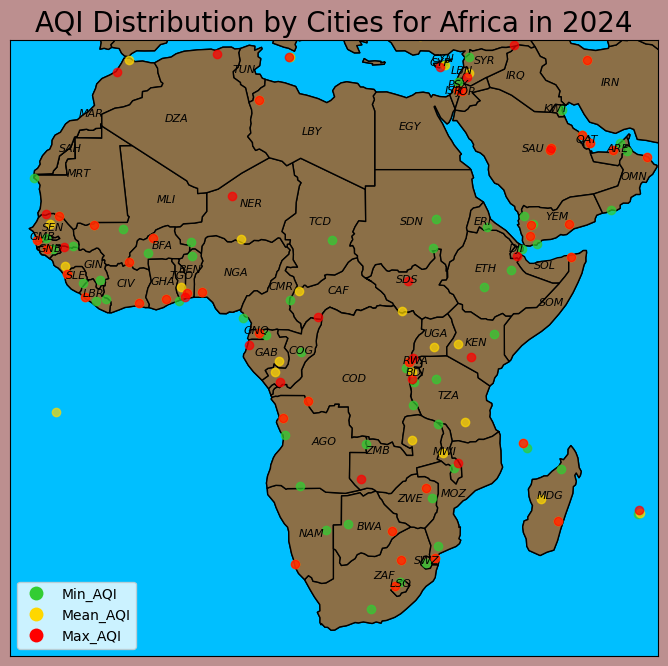

In [10]:
# Displays all measures in Africa

AQI_analysis_cities(continent='Africa')

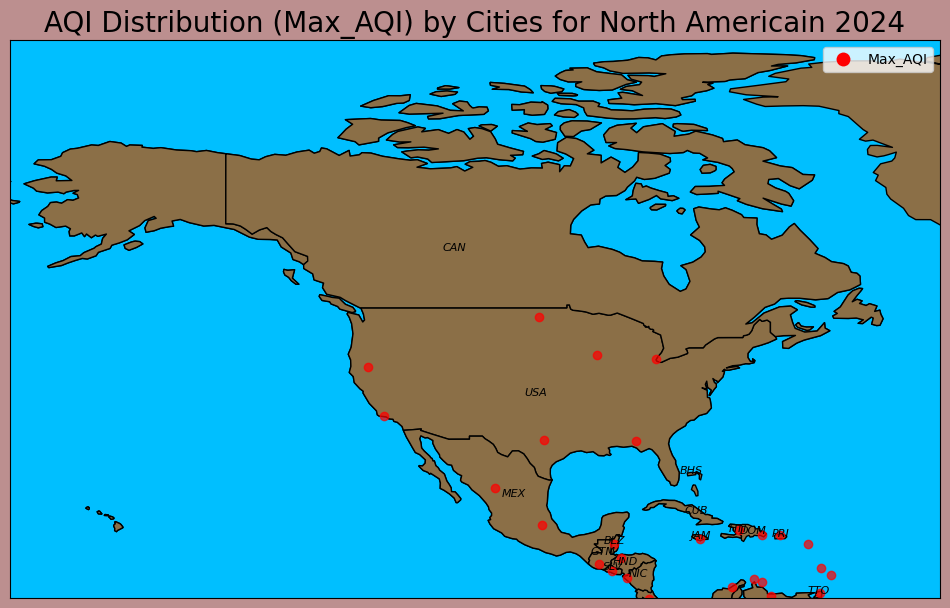

In [ ]:
# Displays the locations of the cities that hold the max AQI in all of NA

# Note: The points in the Caribbean are an example of how a single city can represent all AQI measures (min, mean, and max).

AQI_analysis_cities(continent='North America',max=True)

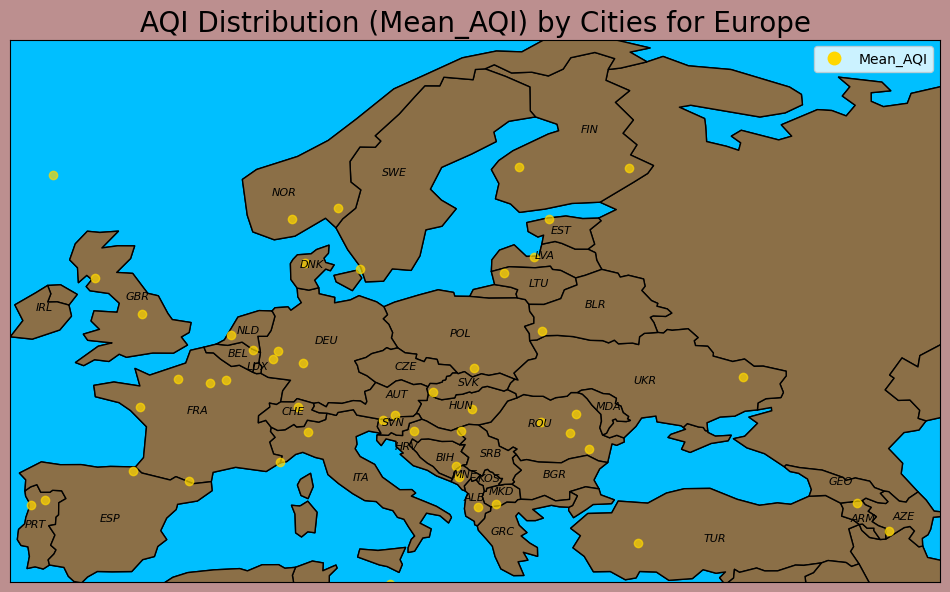

In [18]:
# Displays the locations of the cities that hold the mean AQI in all of Europe


AQI_analysis_cities(continent='Europe',mean=True)

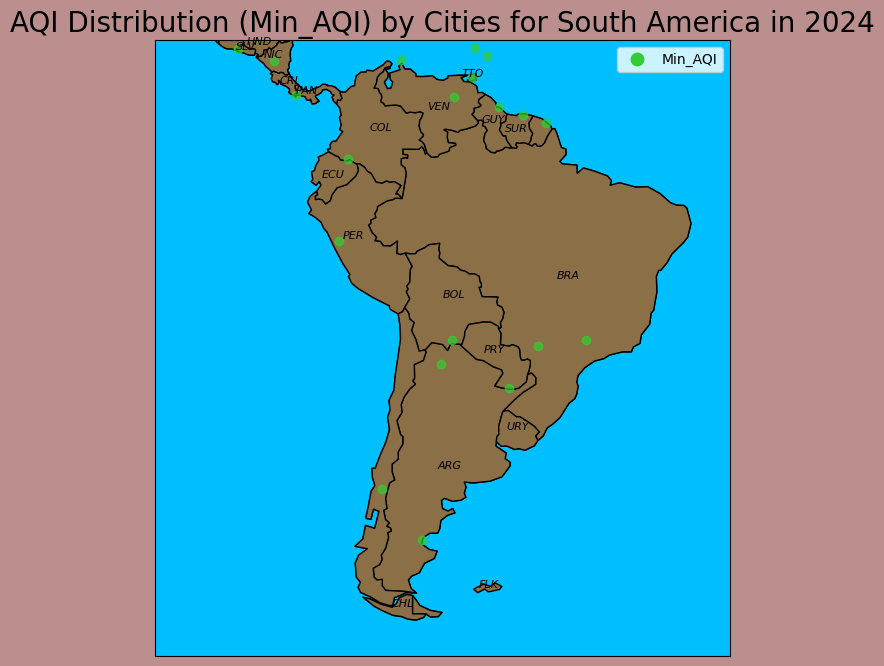

In [17]:
AQI_analysis_cities(continent='South America',min=True)

## Areas for enhancement

- **Add statistics**: Include the count of cities for each AQI measure (min, mean, max) and calculate their percentage representation within the continent.
- **Adjust country labels**: Improve label positioning, clarity, or font size to enhance readability on the map.
- **Interactive Aspect:** Explore the use of interactive modules


#### Visual AQI and Demographic data for Countries

In [12]:
def analysis_countries(continent="",mean_aqi=False,pop=False,deaths=False):
    """
    continent=str,mean_aqi=bool,pop=bool,deaths=bool -> plot
    
    By default, the function will return the full map, displaying where data is available.  
    When a continent is specified, the function will zoom in on that region and display the selected data (one or none) —  
    mean AQI for each country, population percentage, or mortality percentage.
    
    """


    # define the constants

    custom_label = ["No Data"]

    custom_handle = [
     Line2D([],[],marker='s',markersize=10,color='none',markerfacecolor='darkgray')]
    

    # The label of Norway was mispalced the values below will help readjust its postion 

    norway_deaths = Country_AQI_Data_2024.loc[Country_AQI_Data_2024.country_name == 'Norway'].deaths_percent.iloc[0]

    norway_pops = Country_AQI_Data_2024.loc[Country_AQI_Data_2024.country_name == 'Norway'].pop_percent.iloc[0]
     
    norway_aqi = Country_AQI_Data_2024.loc[Country_AQI_Data_2024.country_name == 'Norway'].mean_aqi.iloc[0]
    

#----------------


#----Oceania-----

    if continent == 'Oceania':
        
        fig, ax = plt.subplots(figsize=(12,8))
        plt.axis(oceania_proj)
        # these countries will serve as a background in grey for countries that dont have data
        countries.plot(ax=ax,color='darkgray',edgecolor='k')



        # styling
        ax.set_facecolor('deepskyblue')
        fig.set_facecolor('rosybrown')
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)



        if mean_aqi:

             # plots the data 
        
            Country_AQI_Data_2024.plot(ax=ax, edgecolor='k',column='mean_aqi',cmap='cividis')

            #------
            # create the color bar


            ## create the range of the rates and normalize the data. using the min and max rates in the working dataframe
            norm_pop = mcolors.Normalize(vmin=Country_AQI_Data_2024.mean_aqi.min(),
                         vmax=Country_AQI_Data_2024.mean_aqi.max())
            ## create a scalarmappable which will allow for the rates to be mapped to general color bar
            mappable_pop = plt.cm.ScalarMappable(cmap='cividis',norm=norm_pop)
            ## define the colorbar
            cbar_pop = fig.colorbar(mappable_pop,ax=ax,shrink=0.95)
            cbar_pop.set_label('Mean AQI',fontsize=12)
             # ---- 
            [plt.annotate(Country_AQI_Data_2024.iloc[i].mean_aqi,
                      (Country_AQI_Data_2024.iloc[i].geometry.representative_point().x,
                       Country_AQI_Data_2024.iloc[i].geometry.representative_point().y),
                      ha='center', fontsize=8, fontstyle='italic', annotation_clip=True,color='r')
            for i in np.arange(Country_AQI_Data_2024.shape[0])]

            ## establish the legend
            plt.legend(labels= custom_label  ,
            handles= custom_handle  )

            #----
            # establish the title 

            plt.title("Global Mean AQI Distribution for 2024",fontsize=20)

            plt.show()
        if pop:
            # plots the data 
            Country_AQI_Data_2024.plot(ax=ax, edgecolor='k',column='pop_percent',cmap='cividis')

            #------
            # create the color bar


            ## create the range of the rates and normalize the data. using the min and max rates in the working dataframe
            norm_pop = mcolors.Normalize(vmin=Country_AQI_Data_2024.pop_percent.min(),
                         vmax=Country_AQI_Data_2024.pop_percent.max())
            ## create a scalarmappable which will allow for the rates to be mapped to general color bar
            mappable_pop = plt.cm.ScalarMappable(cmap='cividis',norm=norm_pop)
            ## define the colorbar
            cbar_pop = fig.colorbar(mappable_pop,ax=ax,shrink=0.95)
            cbar_pop.set_label('Population Percent',fontsize=12)
             # ---- 
            [plt.annotate(round(Country_AQI_Data_2024.iloc[i].pop_percent,2),
                      (Country_AQI_Data_2024.iloc[i].geometry.representative_point().x,
                       Country_AQI_Data_2024.iloc[i].geometry.representative_point().y),
                      ha='center', fontsize=8, fontstyle='italic', annotation_clip=True,color='r')
            for i in np.arange(Country_AQI_Data_2024.shape[0])]

            ## establish the legend
            plt.legend(labels= custom_label  ,
            handles= custom_handle  )

            #----
            # establish the title 

            plt.title("Global Population Percentage Distribution for 2024",fontsize=20)

            plt.show()
        if deaths:
            # plots the data 
        
            Country_AQI_Data_2024.plot(ax=ax, edgecolor='k',column='deaths_percent',cmap='cividis')
            

           
            #------
            # create the color bar


            ## create the range of the rates and normalize the data. using the min and max rates in the working dataframe
            norm_pop = mcolors.Normalize(vmin=Country_AQI_Data_2024.deaths_percent.min(),
                         vmax=Country_AQI_Data_2024.deaths_percent.max())
            ## create a scalarmappable which will allow for the rates to be mapped to general color bar
            mappable_pop = plt.cm.ScalarMappable(cmap='cividis',norm=norm_pop)
            ## define the colorbar
            cbar_pop = fig.colorbar(mappable_pop,ax=ax,shrink=0.95)
            cbar_pop.set_label('Death Percent',fontsize=12)
             # ---- 
            [plt.annotate(round(Country_AQI_Data_2024.iloc[i].deaths_percent,2),
                      (Country_AQI_Data_2024.iloc[i].geometry.representative_point().x,
                       Country_AQI_Data_2024.iloc[i].geometry.representative_point().y),
                      ha='center', fontsize=8, fontstyle='italic', annotation_clip=True,color='r')
            for i in np.arange(Country_AQI_Data_2024.shape[0])]

            ## establish the legend
            plt.legend(labels= custom_label  ,
            handles= custom_handle  )

            #----
            # establish the title 

            plt.title("Global Death Percantage Distribution for 2024",fontsize=20)

            plt.show()
        
    
    #----Europe-----
    elif continent == 'Europe':
        fig, ax = plt.subplots(figsize=(12,8))
        plt.axis(europe_proj)
        countries.plot(ax=ax, color='darkgray', edgecolor='k')
        ax.set_facecolor('deepskyblue')
        fig.set_facecolor('rosybrown')
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

        if mean_aqi:
            Country_AQI_Data_2024.plot(ax=ax, edgecolor='k', column='mean_aqi', cmap='cividis')
            norm_pop = mcolors.Normalize(vmin=Country_AQI_Data_2024.mean_aqi.min(), vmax=Country_AQI_Data_2024.mean_aqi.max())
            mappable_pop = plt.cm.ScalarMappable(cmap='cividis', norm=norm_pop)
            cbar_pop = fig.colorbar(mappable_pop, ax=ax, shrink=0.95)
            cbar_pop.set_label('Mean AQI', fontsize=12)
             # adjust the label for Norway
            [plt.annotate(round(Country_AQI_Data_2024.iloc[i].mean_aqi,2),(Country_AQI_Data_2024.iloc[i].geometry.representative_point().x-15,Country_AQI_Data_2024.iloc[i].geometry.representative_point().y-19),
                      ha='center', fontsize=8, fontstyle='italic', annotation_clip=True,color='r')
                        if Country_AQI_Data_2024.iloc[i].mean_aqi == Country_AQI_Data_2024.loc[Country_AQI_Data_2024.country_name == 'Norway'].mean_aqi.iloc[0]
                        else plt.annotate(round(Country_AQI_Data_2024.iloc[i].mean_aqi,2),
                      (Country_AQI_Data_2024.iloc[i].geometry.representative_point().x,
                       Country_AQI_Data_2024.iloc[i].geometry.representative_point().y),
                      ha='center', fontsize=8, fontstyle='italic', annotation_clip=True,color='r')
                        for i in np.arange(Country_AQI_Data_2024.shape[0])]
            plt.legend(labels=custom_label, handles=custom_handle)
            plt.title("Global Mean AQI Distribution for 2024", fontsize=20)
            plt.show()

        if pop:
            Country_AQI_Data_2024.plot(ax=ax, edgecolor='k', column='pop_percent', cmap='cividis')
            norm_pop = mcolors.Normalize(vmin=Country_AQI_Data_2024.pop_percent.min(), vmax=Country_AQI_Data_2024.pop_percent.max())
            mappable_pop = plt.cm.ScalarMappable(cmap='cividis', norm=norm_pop)
            cbar_pop = fig.colorbar(mappable_pop, ax=ax, shrink=0.95)
            cbar_pop.set_label('Population Percent', fontsize=12)
            # adjust the label for Norway
            [plt.annotate(round(Country_AQI_Data_2024.iloc[i].pop_percent,2),(Country_AQI_Data_2024.iloc[i].geometry.representative_point().x-15,Country_AQI_Data_2024.iloc[i].geometry.representative_point().y-19),
                      ha='center', fontsize=8, fontstyle='italic', annotation_clip=True,color='r')
                        if Country_AQI_Data_2024.iloc[i].pop_percent == Country_AQI_Data_2024.loc[Country_AQI_Data_2024.country_name == 'Norway'].pop_percent.iloc[0]
                        else plt.annotate(round(Country_AQI_Data_2024.iloc[i].pop_percent,2),
                      (Country_AQI_Data_2024.iloc[i].geometry.representative_point().x,
                       Country_AQI_Data_2024.iloc[i].geometry.representative_point().y),
                      ha='center', fontsize=8, fontstyle='italic', annotation_clip=True,color='r')
                        for i in np.arange(Country_AQI_Data_2024.shape[0])]
            plt.legend(labels=custom_label, handles=custom_handle)
            plt.title("Global Population Percentage Distribution for 2024", fontsize=20)
            plt.show()

        if deaths:
            Country_AQI_Data_2024.plot(ax=ax, edgecolor='k', column='deaths_percent', cmap='cividis')
            norm_pop = mcolors.Normalize(vmin=Country_AQI_Data_2024.deaths_percent.min(), vmax=Country_AQI_Data_2024.deaths_percent.max())
            mappable_pop = plt.cm.ScalarMappable(cmap='cividis', norm=norm_pop)
            cbar_pop = fig.colorbar(mappable_pop, ax=ax, shrink=0.95)
            cbar_pop.set_label('Death Percent', fontsize=12)
            # adjust the label for Norway
            [plt.annotate(round(Country_AQI_Data_2024.iloc[i].deaths_percent,2),(Country_AQI_Data_2024.iloc[i].geometry.representative_point().x-15,Country_AQI_Data_2024.iloc[i].geometry.representative_point().y-19),
                      ha='center', fontsize=8, fontstyle='italic', annotation_clip=True,color='r')
                        if Country_AQI_Data_2024.iloc[i].deaths_percent == Country_AQI_Data_2024.loc[Country_AQI_Data_2024.country_name == 'Norway'].deaths_percent.iloc[0]
                        else plt.annotate(round(Country_AQI_Data_2024.iloc[i].deaths_percent,2),
                      (Country_AQI_Data_2024.iloc[i].geometry.representative_point().x,
                       Country_AQI_Data_2024.iloc[i].geometry.representative_point().y),
                      ha='center', fontsize=8, fontstyle='italic', annotation_clip=True,color='r')
                        for i in np.arange(Country_AQI_Data_2024.shape[0])]
            plt.legend(labels=custom_label, handles=custom_handle)
            plt.title("Global Death Percantage Distribution for 2024", fontsize=20)
            plt.show()


    #----Africa-----
    elif continent == 'Africa':
        fig, ax = plt.subplots(figsize=(12,8))
        plt.axis(africa_proj)
        countries.plot(ax=ax, color='darkgray', edgecolor='k')
        ax.set_facecolor('deepskyblue')
        fig.set_facecolor('rosybrown')
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

        if mean_aqi:
            Country_AQI_Data_2024.plot(ax=ax, edgecolor='k', column='mean_aqi', cmap='cividis')
            norm_pop = mcolors.Normalize(vmin=Country_AQI_Data_2024.mean_aqi.min(), vmax=Country_AQI_Data_2024.mean_aqi.max())
            mappable_pop = plt.cm.ScalarMappable(cmap='cividis', norm=norm_pop)
            cbar_pop = fig.colorbar(mappable_pop, ax=ax, shrink=0.95)
            cbar_pop.set_label('Mean AQI', fontsize=12)
            [plt.annotate(Country_AQI_Data_2024.iloc[i].mean_aqi,
                          (Country_AQI_Data_2024.iloc[i].geometry.representative_point().x,
                           Country_AQI_Data_2024.iloc[i].geometry.representative_point().y),
                          ha='center', fontsize=8, fontstyle='italic', annotation_clip=True, color='r')
             for i in np.arange(Country_AQI_Data_2024.shape[0])]
            plt.legend(labels=custom_label, handles=custom_handle)
            plt.title("Global Mean AQI Distribution for 2024", fontsize=20)
            plt.show()

        if pop:
            Country_AQI_Data_2024.plot(ax=ax, edgecolor='k', column='pop_percent', cmap='cividis')
            norm_pop = mcolors.Normalize(vmin=Country_AQI_Data_2024.pop_percent.min(), vmax=Country_AQI_Data_2024.pop_percent.max())
            mappable_pop = plt.cm.ScalarMappable(cmap='cividis', norm=norm_pop)
            cbar_pop = fig.colorbar(mappable_pop, ax=ax, shrink=0.95)
            cbar_pop.set_label('Population Percent', fontsize=12)
            [plt.annotate(round(Country_AQI_Data_2024.iloc[i].pop_percent, 2),
                          (Country_AQI_Data_2024.iloc[i].geometry.representative_point().x,
                           Country_AQI_Data_2024.iloc[i].geometry.representative_point().y),
                          ha='center', fontsize=8, fontstyle='italic', annotation_clip=True, color='r')
             for i in np.arange(Country_AQI_Data_2024.shape[0])]
            plt.legend(labels=custom_label, handles=custom_handle)
            plt.title("Global Population Percentage Distribution for 2024", fontsize=20)
            plt.show()

        if deaths:
            Country_AQI_Data_2024.plot(ax=ax, edgecolor='k', column='deaths_percent', cmap='cividis')
            norm_pop = mcolors.Normalize(vmin=Country_AQI_Data_2024.deaths_percent.min(), vmax=Country_AQI_Data_2024.deaths_percent.max())
            mappable_pop = plt.cm.ScalarMappable(cmap='cividis', norm=norm_pop)
            cbar_pop = fig.colorbar(mappable_pop, ax=ax, shrink=0.95)
            cbar_pop.set_label('Death Percent', fontsize=12)
            [plt.annotate(round(Country_AQI_Data_2024.iloc[i].deaths_percent, 2),
                          (Country_AQI_Data_2024.iloc[i].geometry.representative_point().x,
                           Country_AQI_Data_2024.iloc[i].geometry.representative_point().y),
                          ha='center', fontsize=8, fontstyle='italic', annotation_clip=True, color='r')
             for i in np.arange(Country_AQI_Data_2024.shape[0])]
            plt.legend(labels=custom_label, handles=custom_handle)
            plt.title("Global Death Percantage Distribution for 2024", fontsize=20)
            plt.show()



#----Asia-----
    elif continent == 'Asia':
        fig, ax = plt.subplots(figsize=(12,8))
        plt.axis(asia_proj)
        countries.plot(ax=ax, color='darkgray', edgecolor='k')
        ax.set_facecolor('deepskyblue')
        fig.set_facecolor('rosybrown')
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

        if mean_aqi:
            Country_AQI_Data_2024.plot(ax=ax, edgecolor='k', column='mean_aqi', cmap='cividis')
            norm_pop = mcolors.Normalize(vmin=Country_AQI_Data_2024.mean_aqi.min(), vmax=Country_AQI_Data_2024.mean_aqi.max())
            mappable_pop = plt.cm.ScalarMappable(cmap='cividis', norm=norm_pop)
            cbar_pop = fig.colorbar(mappable_pop, ax=ax, shrink=0.95)
            cbar_pop.set_label('Mean AQI', fontsize=12)
            [plt.annotate(Country_AQI_Data_2024.iloc[i].mean_aqi,
                          (Country_AQI_Data_2024.iloc[i].geometry.representative_point().x,
                           Country_AQI_Data_2024.iloc[i].geometry.representative_point().y),
                          ha='center', fontsize=8, fontstyle='italic', annotation_clip=True, color='r')
             for i in np.arange(Country_AQI_Data_2024.shape[0])]
            plt.legend(labels=custom_label, handles=custom_handle)
            plt.title("Global Mean AQI Distribution for 2024", fontsize=20)
            plt.show()

        if pop:
            Country_AQI_Data_2024.plot(ax=ax, edgecolor='k', column='pop_percent', cmap='cividis')
            norm_pop = mcolors.Normalize(vmin=Country_AQI_Data_2024.pop_percent.min(), vmax=Country_AQI_Data_2024.pop_percent.max())
            mappable_pop = plt.cm.ScalarMappable(cmap='cividis', norm=norm_pop)
            cbar_pop = fig.colorbar(mappable_pop, ax=ax, shrink=0.95)
            cbar_pop.set_label('Population Percent', fontsize=12)
            [plt.annotate(round(Country_AQI_Data_2024.iloc[i].pop_percent, 2),
                          (Country_AQI_Data_2024.iloc[i].geometry.representative_point().x,
                           Country_AQI_Data_2024.iloc[i].geometry.representative_point().y),
                          ha='center', fontsize=8, fontstyle='italic', annotation_clip=True, color='r')
             for i in np.arange(Country_AQI_Data_2024.shape[0])]
            plt.legend(labels=custom_label, handles=custom_handle)
            plt.title("Global Population Percentage Distribution for 2024", fontsize=20)
            plt.show()

        if deaths:
            Country_AQI_Data_2024.plot(ax=ax, edgecolor='k', column='deaths_percent', cmap='cividis')
            norm_pop = mcolors.Normalize(vmin=Country_AQI_Data_2024.deaths_percent.min(), vmax=Country_AQI_Data_2024.deaths_percent.max())
            mappable_pop = plt.cm.ScalarMappable(cmap='cividis', norm=norm_pop)
            cbar_pop = fig.colorbar(mappable_pop, ax=ax, shrink=0.95)
            cbar_pop.set_label('Death Percent', fontsize=12)
            [plt.annotate(round(Country_AQI_Data_2024.iloc[i].deaths_percent, 2),
                          (Country_AQI_Data_2024.iloc[i].geometry.representative_point().x,
                           Country_AQI_Data_2024.iloc[i].geometry.representative_point().y),
                          ha='center', fontsize=8, fontstyle='italic', annotation_clip=True, color='r')
             for i in np.arange(Country_AQI_Data_2024.shape[0])]
            plt.legend(labels=custom_label, handles=custom_handle)
            plt.title("Global Death Percantage Distribution for 2024", fontsize=20)
            plt.show()


#----North America-----
    elif continent == 'North America':
        fig, ax = plt.subplots(figsize=(12,8))
        plt.axis(na_proj)
        countries.plot(ax=ax, color='darkgray', edgecolor='k')
        ax.set_facecolor('deepskyblue')
        fig.set_facecolor('rosybrown')
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

        if mean_aqi:
            Country_AQI_Data_2024.plot(ax=ax, edgecolor='k', column='mean_aqi', cmap='cividis')
            norm_pop = mcolors.Normalize(vmin=Country_AQI_Data_2024.mean_aqi.min(), vmax=Country_AQI_Data_2024.mean_aqi.max())
            mappable_pop = plt.cm.ScalarMappable(cmap='cividis', norm=norm_pop)
            cbar_pop = fig.colorbar(mappable_pop, ax=ax, shrink=0.95)
            cbar_pop.set_label('Mean AQI', fontsize=12)
            [plt.annotate(Country_AQI_Data_2024.iloc[i].mean_aqi,
                          (Country_AQI_Data_2024.iloc[i].geometry.representative_point().x,
                           Country_AQI_Data_2024.iloc[i].geometry.representative_point().y),
                          ha='center', fontsize=8, fontstyle='italic', annotation_clip=True, color='r')
             for i in np.arange(Country_AQI_Data_2024.shape[0])]
            plt.legend(labels=custom_label, handles=custom_handle)
            plt.title("Global Mean AQI Distribution for 2024", fontsize=20)
            plt.show()

        if pop:
            Country_AQI_Data_2024.plot(ax=ax, edgecolor='k', column='pop_percent', cmap='cividis')
            norm_pop = mcolors.Normalize(vmin=Country_AQI_Data_2024.pop_percent.min(), vmax=Country_AQI_Data_2024.pop_percent.max())
            mappable_pop = plt.cm.ScalarMappable(cmap='cividis', norm=norm_pop)
            cbar_pop = fig.colorbar(mappable_pop, ax=ax, shrink=0.95)
            cbar_pop.set_label('Population Percent', fontsize=12)
            [plt.annotate(round(Country_AQI_Data_2024.iloc[i].pop_percent, 2),
                          (Country_AQI_Data_2024.iloc[i].geometry.representative_point().x,
                           Country_AQI_Data_2024.iloc[i].geometry.representative_point().y),
                          ha='center', fontsize=8, fontstyle='italic', annotation_clip=True, color='r')
             for i in np.arange(Country_AQI_Data_2024.shape[0])]
            plt.legend(labels=custom_label, handles=custom_handle)
            plt.title("Global Population Percentage Distribution for 2024", fontsize=20)
            plt.show()

        if deaths:
            Country_AQI_Data_2024.plot(ax=ax, edgecolor='k', column='deaths_percent', cmap='cividis')
            norm_pop = mcolors.Normalize(vmin=Country_AQI_Data_2024.deaths_percent.min(), vmax=Country_AQI_Data_2024.deaths_percent.max())
            mappable_pop = plt.cm.ScalarMappable(cmap='cividis', norm=norm_pop)
            cbar_pop = fig.colorbar(mappable_pop, ax=ax, shrink=0.95)
            cbar_pop.set_label('Death Percent', fontsize=12)
            [plt.annotate(round(Country_AQI_Data_2024.iloc[i].deaths_percent, 2),
                          (Country_AQI_Data_2024.iloc[i].geometry.representative_point().x,
                           Country_AQI_Data_2024.iloc[i].geometry.representative_point().y),
                          ha='center', fontsize=8, fontstyle='italic', annotation_clip=True, color='r')
             for i in np.arange(Country_AQI_Data_2024.shape[0])]
            plt.legend(labels=custom_label, handles=custom_handle)
            plt.title("Global Death Percantage Distribution for 2024", fontsize=20)
            plt.show()




#----South America-----
    elif continent == 'South America':
        fig, ax = plt.subplots(figsize=(12,8))
        plt.axis(sa_proj)
        countries.plot(ax=ax, color='darkgray', edgecolor='k')
        ax.set_facecolor('deepskyblue')
        fig.set_facecolor('rosybrown')
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

        if mean_aqi:
            Country_AQI_Data_2024.plot(ax=ax, edgecolor='k', column='mean_aqi', cmap='cividis')
            norm_pop = mcolors.Normalize(vmin=Country_AQI_Data_2024.mean_aqi.min(), vmax=Country_AQI_Data_2024.mean_aqi.max())
            mappable_pop = plt.cm.ScalarMappable(cmap='cividis', norm=norm_pop)
            cbar_pop = fig.colorbar(mappable_pop, ax=ax, shrink=0.95)
            cbar_pop.set_label('Mean AQI', fontsize=12)
            [plt.annotate(Country_AQI_Data_2024.iloc[i].mean_aqi,
                          (Country_AQI_Data_2024.iloc[i].geometry.representative_point().x,
                           Country_AQI_Data_2024.iloc[i].geometry.representative_point().y),
                          ha='center', fontsize=8, fontstyle='italic', annotation_clip=True, color='r')
             for i in np.arange(Country_AQI_Data_2024.shape[0])]
            plt.legend(labels=custom_label, handles=custom_handle)
            plt.title("Global Mean AQI Distribution for 2024", fontsize=20)
            plt.show()

        if pop:
            Country_AQI_Data_2024.plot(ax=ax, edgecolor='k', column='pop_percent', cmap='cividis')
            norm_pop = mcolors.Normalize(vmin=Country_AQI_Data_2024.pop_percent.min(), vmax=Country_AQI_Data_2024.pop_percent.max())
            mappable_pop = plt.cm.ScalarMappable(cmap='cividis', norm=norm_pop)
            cbar_pop = fig.colorbar(mappable_pop, ax=ax, shrink=0.95)
            cbar_pop.set_label('Population Percent', fontsize=12)
            [plt.annotate(round(Country_AQI_Data_2024.iloc[i].pop_percent, 2),
                          (Country_AQI_Data_2024.iloc[i].geometry.representative_point().x,
                           Country_AQI_Data_2024.iloc[i].geometry.representative_point().y),
                          ha='center', fontsize=8, fontstyle='italic', annotation_clip=True, color='r')
             for i in np.arange(Country_AQI_Data_2024.shape[0])]
            plt.legend(labels=custom_label, handles=custom_handle)
            plt.title("Global Population Percentage Distribution for 2024", fontsize=20)
            plt.show()

        if deaths:
            Country_AQI_Data_2024.plot(ax=ax, edgecolor='k', column='deaths_percent', cmap='cividis')
            norm_pop = mcolors.Normalize(vmin=Country_AQI_Data_2024.deaths_percent.min(), vmax=Country_AQI_Data_2024.deaths_percent.max())
            mappable_pop = plt.cm.ScalarMappable(cmap='cividis', norm=norm_pop)
            cbar_pop = fig.colorbar(mappable_pop, ax=ax, shrink=0.95)
            cbar_pop.set_label('Death Percent', fontsize=12)
            [plt.annotate(round(Country_AQI_Data_2024.iloc[i].deaths_percent, 2),
                          (Country_AQI_Data_2024.iloc[i].geometry.representative_point().x,
                           Country_AQI_Data_2024.iloc[i].geometry.representative_point().y),
                          ha='center', fontsize=8, fontstyle='italic', annotation_clip=True, color='r')
             for i in np.arange(Country_AQI_Data_2024.shape[0])]
            plt.legend(labels=custom_label, handles=custom_handle)
            plt.title("Global Death Percantage Distribution for 2024", fontsize=20)
            plt.show()



    else:
        fig, ax = plt.subplots(figsize=(12,8))

        countries.plot(ax=ax,color='darkgray',edgecolor='k')

        Country_AQI_Data_2024.plot(ax=ax, edgecolor='k',color='darkgreen')

        # styling
        ax.set_facecolor('deepskyblue')
        fig.set_facecolor('rosybrown')
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)



        ## establish the legend
        plt.legend(labels= custom_label+['Avaiable Data']  ,
           handles= custom_handle + [Line2D([],[],marker='s',color='none',markerfacecolor='darkgreen',markersize=10)]  )


        plt.show()









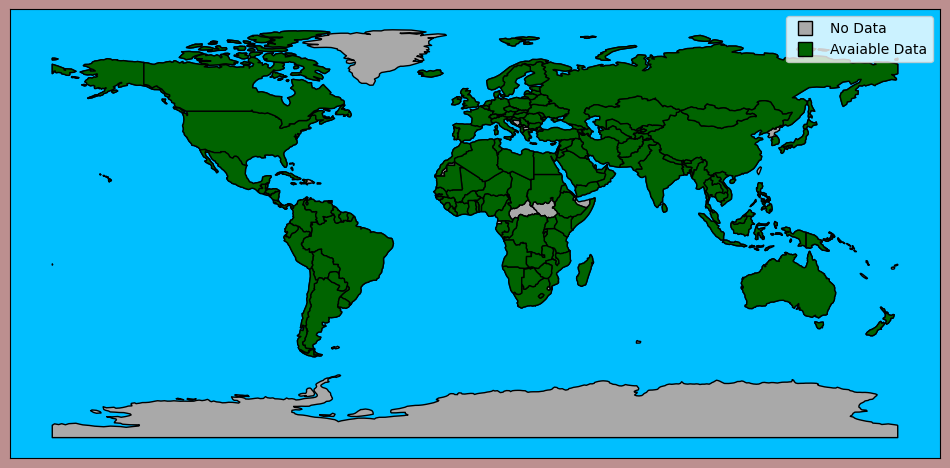

In [13]:
# display the countries that have data
analysis_countries()

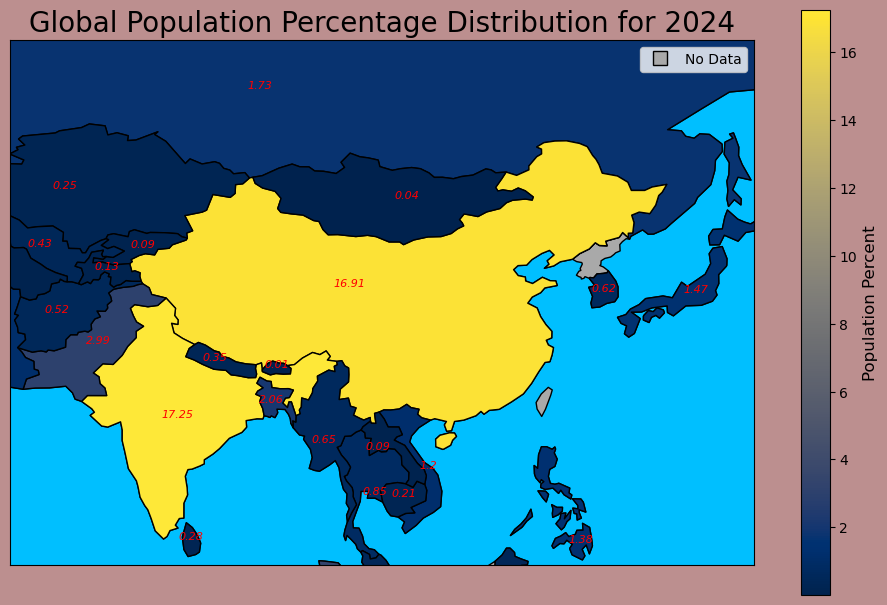

In [14]:
# display the population density plot of Asia

analysis_countries(continent='Asia',pop=True)

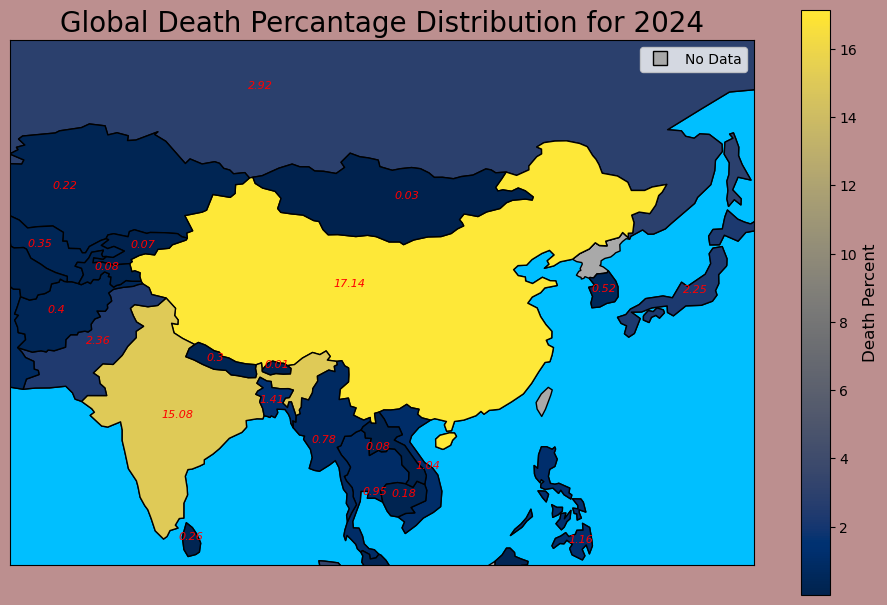

In [15]:
# display the population density plot of Asia

analysis_countries(continent='Asia',deaths=True)

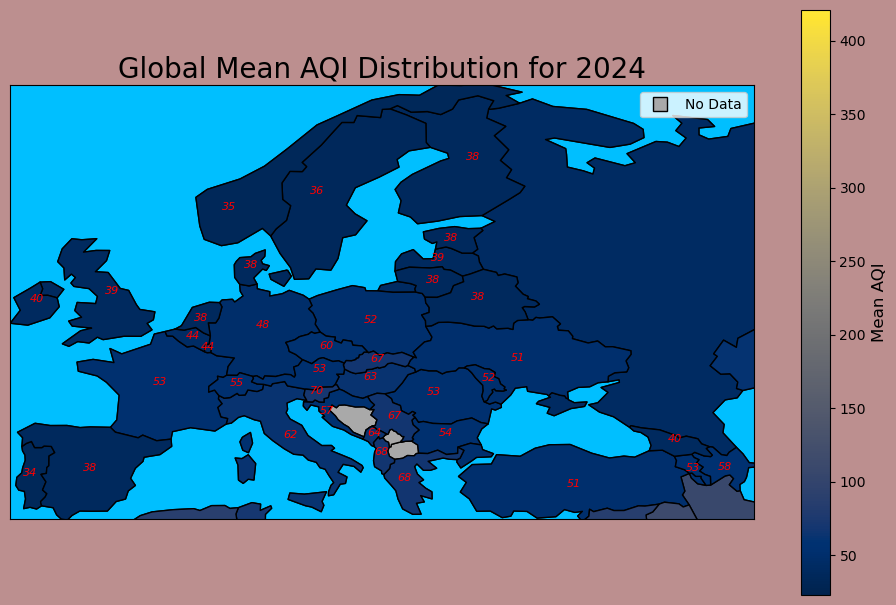

In [16]:
# display the mean AQI distribution plot of Europe

analysis_countries(continent='Europe',mean_aqi=True)